In [15]:
import joblib
import numpy as np
import pandas as pd
import sys
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
import plotly.express as px

# Add the 'src' directory to the system path
sys.path.append('..') 

# Import custom plotting functions and class names
from src.utils import plot_confusion_matrix, plot_error_examples, CLASS_NAMES

print("Imports complete. Helper functions loaded.")
print(f"Class Names: {CLASS_NAMES}")

Imports complete. Helper functions loaded.
Class Names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [3]:
# --- Load Test Data ---
TEST_DATA_PATH = "../models/test_data.pkl"
# This data was already scaled (0-1) by the training script
X_test_scaled_2d, y_test = joblib.load(TEST_DATA_PATH)

print(f"Test data loaded: X_test shape {X_test_scaled_2d.shape}, y_test shape {y_test.shape}")

# --- Load Models ---
SVM_MODEL_PATH = "../models/svm_model.pkl"
CNN_MODEL_PATH = "../models/cnn_model.keras"

svm_model = joblib.load(SVM_MODEL_PATH)
cnn_model = tf.keras.models.load_model(CNN_MODEL_PATH)

print("Models loaded successfully.")

Test data loaded: X_test shape (10000, 28, 28), y_test shape (10000,)
Models loaded successfully.


In [4]:
# Prepare data for each model's expected input shape

# 1. Flattened data for SVM
X_test_flat = X_test_scaled_2d.reshape(X_test_scaled_2d.shape[0], -1)
print(f"SVM test data shape: {X_test_flat.shape}")

# 2. Reshaped 4D data for CNN (add channel dimension)
X_test_cnn = X_test_scaled_2d.reshape(X_test_scaled_2d.shape[0], 28, 28, 1)
print(f"CNN test data shape: {X_test_cnn.shape}")

SVM test data shape: (10000, 784)
CNN test data shape: (10000, 28, 28, 1)


In [5]:
print("--- SVM Model Evaluation ---")
y_pred_svm = svm_model.predict(X_test_flat)

print("\nClassification Report (SVM):")
print(classification_report(y_test, y_pred_svm, target_names=CLASS_NAMES))

# Plot confusion matrix for SVM
cm_svm = confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(cm_svm, class_names=CLASS_NAMES, title="SVM Confusion Matrix")

--- SVM Model Evaluation ---

Classification Report (SVM):
              precision    recall  f1-score   support

 T-shirt/top       0.82      0.81      0.82      1000
     Trouser       0.99      0.95      0.97      1000
    Pullover       0.77      0.79      0.78      1000
       Dress       0.84      0.89      0.86      1000
        Coat       0.78      0.79      0.79      1000
      Sandal       0.95      0.94      0.94      1000
       Shirt       0.67      0.62      0.65      1000
     Sneaker       0.92      0.93      0.92      1000
         Bag       0.96      0.97      0.96      1000
  Ankle boot       0.94      0.94      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



--- SVM Error Analysis ---
SVM total errors: 1361 out of 10000


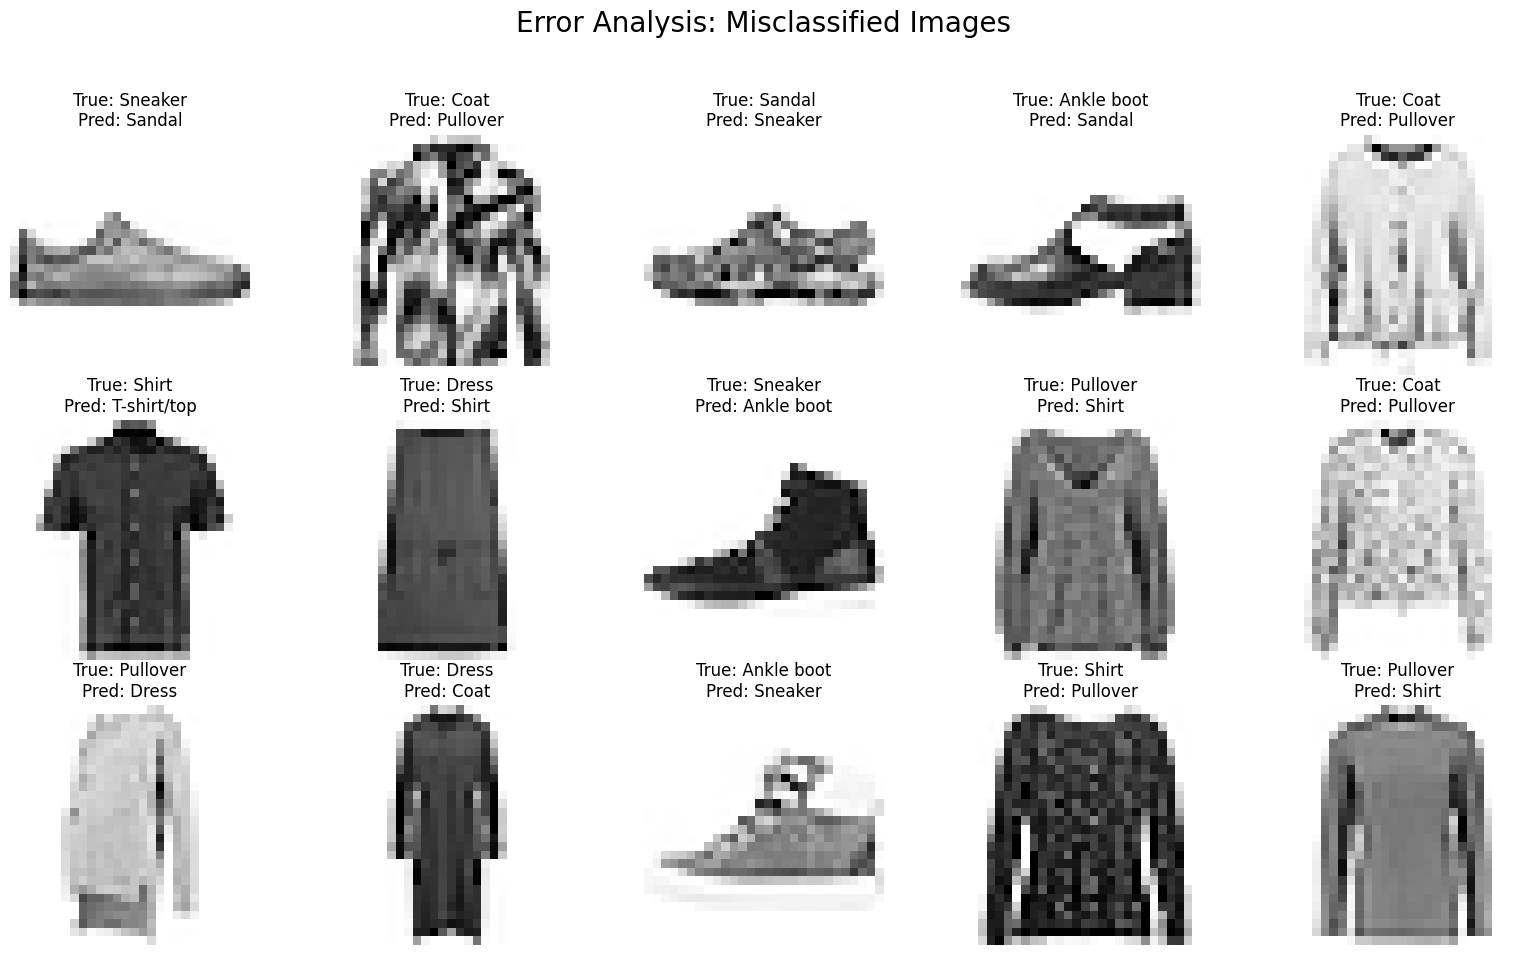

In [14]:
print("--- SVM Error Analysis ---")

# Find indices of incorrect predictions
errors_mask_svm = y_pred_svm != y_test

# Get the corresponding data (use the 2D images for plotting)
X_test_errors_svm = X_test_scaled_2d[errors_mask_svm]
y_true_errors_svm = y_test[errors_mask_svm]

# Użyj .values, aby poprawnie filtrować tablicę NumPy
y_pred_errors_svm = y_pred_svm[errors_mask_svm] 

print(f"SVM total errors: {len(y_true_errors_svm)} out of {len(y_test)}")

# Plot examples
plot_error_examples(X_test_errors_svm, y_true_errors_svm, y_pred_errors_svm, CLASS_NAMES)

In [ ]:
print("--- CNN Model Evaluation ---")
# CNN outputs probabilities, we need the index of the highest probability
y_pred_proba_cnn = cnn_model.predict(X_test_cnn)
y_pred_cnn = np.argmax(y_pred_proba_cnn, axis=1)

print("\nClassification Report (CNN):")
print(classification_report(y_test, y_pred_cnn, target_names=CLASS_NAMES))

# Plot confusion matrix for CNN
cm_cnn = confusion_matrix(y_test, y_pred_cnn)
plot_confusion_matrix(cm_cnn, class_names=CLASS_NAMES, title="CNN Confusion Matrix")


--- CNN Model Evaluation ---
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report (CNN):
              precision    recall  f1-score   support

 T-shirt/top       0.83      0.88      0.85      1000
     Trouser       0.98      0.98      0.98      1000
    Pullover       0.76      0.92      0.83      1000
       Dress       0.91      0.91      0.91      1000
        Coat       0.89      0.76      0.82      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.75      0.65      0.70      1000
     Sneaker       0.92      0.98      0.95      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.99      0.93      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



--- CNN Error Analysis ---
CNN total errors: 1033 out of 10000


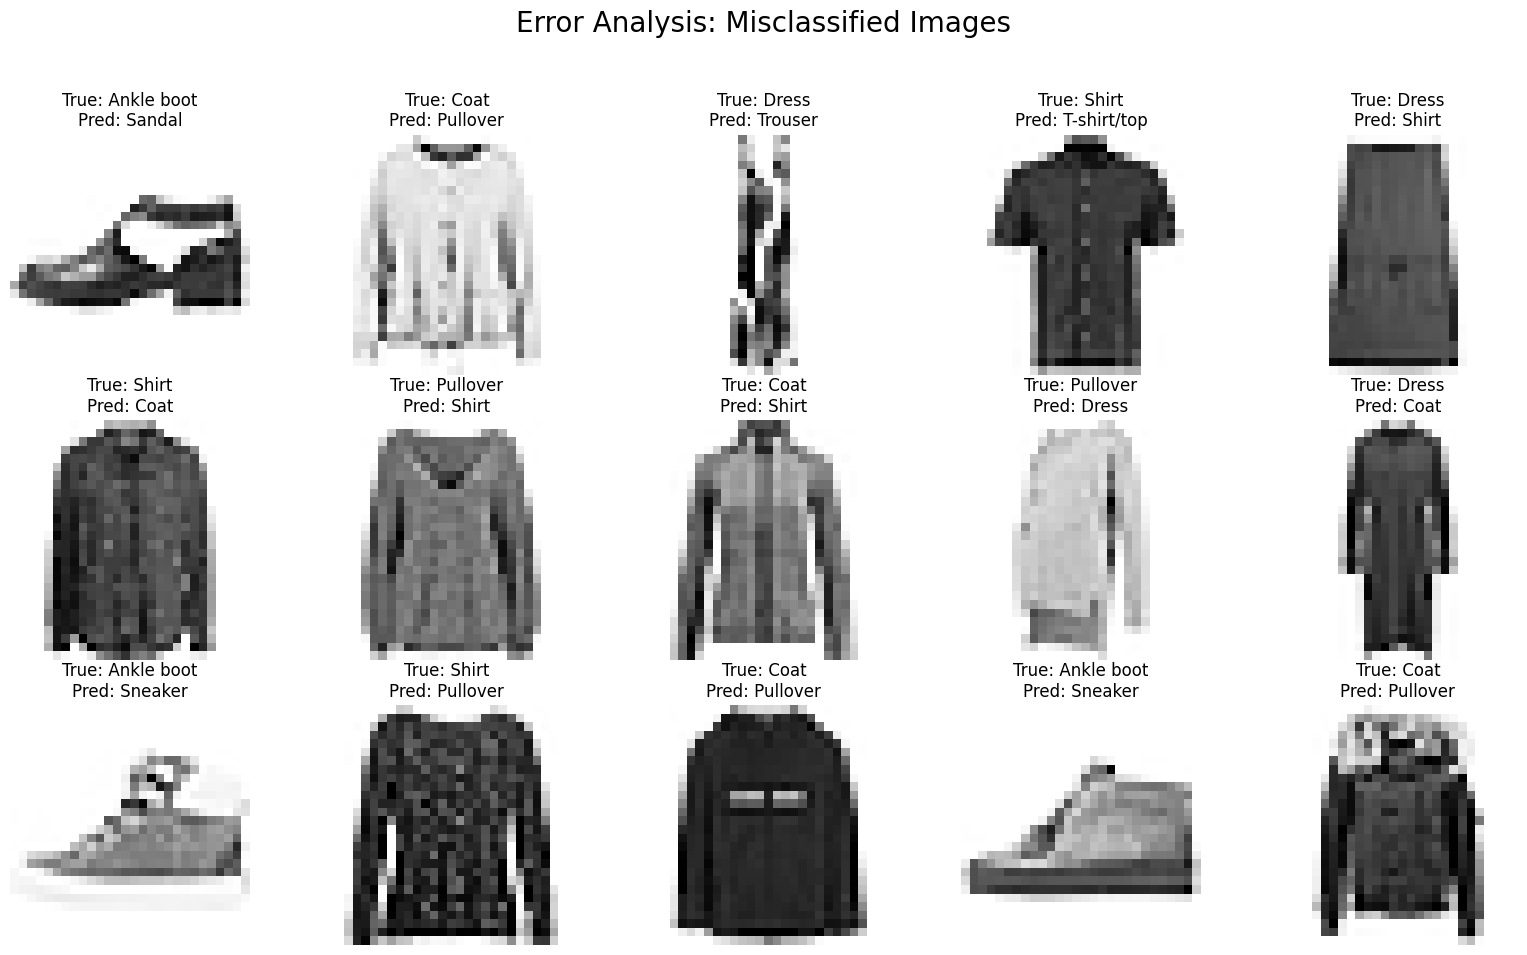

In [12]:
print("--- CNN Error Analysis ---")

# Find indices of incorrect predictions
errors_mask = y_pred_cnn != y_test

# Get the corresponding data (use the 2D images for plotting)
X_test_errors = X_test_scaled_2d[errors_mask]
y_true_errors = y_test[errors_mask]
y_pred_errors_cnn = y_pred_cnn[errors_mask]

print(f"CNN total errors: {len(y_true_errors)} out of {len(y_test)}")

# Plot examples
plot_error_examples(X_test_errors, y_true_errors, y_pred_errors_cnn, CLASS_NAMES)

In [16]:
print("--- Final Model Comparison: Per-Class Accuracy ---")

per_class_accuracy = []

# Calculate accuracy for each class for both models
for i in range(len(CLASS_NAMES)):
    class_name = CLASS_NAMES[i]
    
    # Create a mask for the current class
    class_mask = (y_test == i)
    
    # Get subsets of the data
    y_test_class = y_test[class_mask]
    y_pred_svm_class = y_pred_svm[class_mask]
    y_pred_cnn_class = y_pred_cnn[class_mask]
    
    # Calculate accuracy
    acc_svm = np.sum(y_test_class == y_pred_svm_class) / len(y_test_class)
    acc_cnn = np.sum(y_test_class == y_pred_cnn_class) / len(y_test_class)
    
    # Add results to the list
    per_class_accuracy.append({'Class': class_name, 'Model': 'SVM', 'Accuracy': acc_svm})
    per_class_accuracy.append({'Class': class_name, 'Model': 'CNN', 'Accuracy': acc_cnn})

# Create a DataFrame from the results
df_accuracy = pd.DataFrame(per_class_accuracy)

# Plot the bar chart
fig = px.bar(df_accuracy, 
             x='Class', 
             y='Accuracy', 
             color='Model',      # Color by model (SVM vs CNN)
             barmode='group',    # Group bars side-by-side
             title='Per-Class Accuracy: SVM vs. CNN')

fig.update_layout(yaxis_title="Accuracy (0.0 to 1.0)", 
                  xaxis_title="Clothing Class",
                  legend_title="Model")
fig.show()

--- Final Model Comparison: Per-Class Accuracy ---
